In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [388]:
# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)

cur = conn.cursor()



# List all unique cities where customers are located.

In [389]:
query=""" select distinct(customer_city) from customers """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [390]:
query=""" select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query)

data=cur.fetchall()

'total count of orders placed in 2017 are:', data[0][0] 

('total count of orders placed in 2017 are:', 135361)

 # Find the total sales per category.

In [391]:
query = """ SELECT products.`product category` as category, round(SUM(payments.payment_value),2) as sales
            FROM products JOIN order_items ON products.product_id = order_items.product_id
            JOIN payments ON payments.order_id = order_items.order_id GROUP BY category;
        """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['category','sales'])
df

,category,sales


In [392]:
cur = conn.cursor()
cur.execute("DESCRIBE products;")
for row in cur.fetchall():
    print(row)


('product_id', 'text', 'YES', '', None, '')
('product category', 'text', 'YES', '', None, '')
('product_name_length', 'int', 'YES', '', None, '')
('product_description_length', 'int', 'YES', '', None, '')
('product_photos_qty', 'int', 'YES', '', None, '')
('product_weight_g', 'int', 'YES', '', None, '')
('product_length_cm', 'int', 'YES', '', None, '')
('product_height_cm', 'int', 'YES', '', None, '')
('product_width_cm', 'int', 'YES', '', None, '')


# 4. Calculate the percentage of orders that were paid in installments.

In [393]:
query="""select (sum(case when payment_installments>=1 then 1 else 0 end))/count(*)*100.0
        as percentage from payments
"""
cur.execute(query)
data=cur.fetchall()
data

[(Decimal('100.00000'),)]

# Count the number of customers from each state. 

   states  Customer_count
0      SP          129838
1      RJ           40007
2      MG           36184
3      RS           16977
4      PR           15703
5      SC           11287
6      BA           10486
7      DF            6640
8      ES            6321
9      GO            6277
10     PE            5125
11     CE            4142
12     PA            3036
13     MT            2836
14     MA            2320
15     MS            2220
16     PB            1654
17     PI            1531
18     RN            1503
19     AL            1283
20     SE            1081
21     TO             874
22     RO             787
23     AM             464
24     AC             252
25     AP             214
26     RR             143


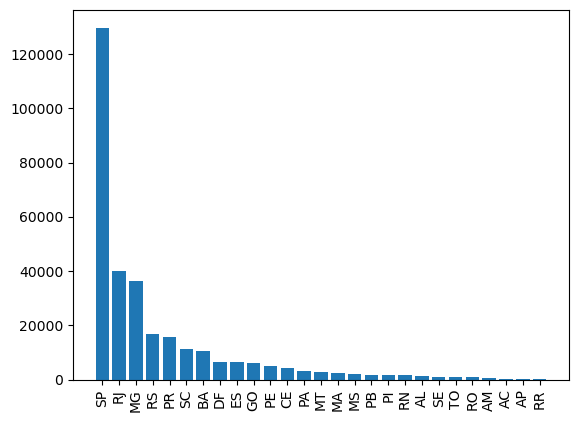

In [394]:
query=""" select customer_state,count(customer_id)
        from customers group by customer_state
        order by count(customer_id) desc"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["states","Customer_count"])
print(df)
plt.bar(df["states"],df["Customer_count"])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month in 2018.

      Months  Total Orders
0       July         18884
1      March         21642
2    January         21817
3        May         20630
4      April         20825
5   February         20190
6       June         18510
7     August         19539
8  September            48
9    October            12


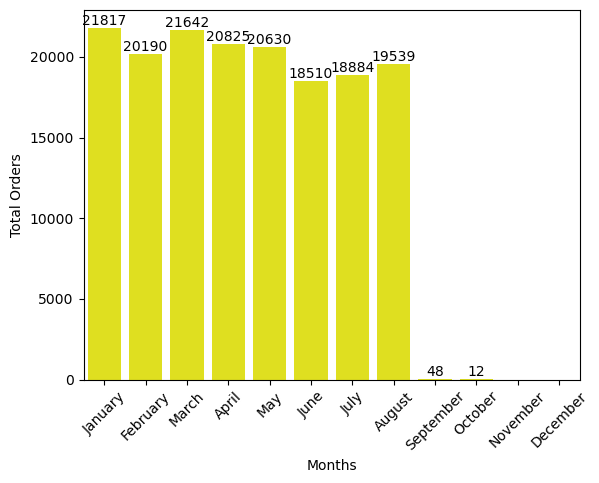

In [395]:
query="""
   SELECT monthname(order_purchase_timestamp) AS month,
       COUNT(*) AS total_orders
FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY month
"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Months','Total Orders'])
o=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
print(df)
a=sns.barplot(x=df['Months'],y=df['Total Orders'],data=df,order=o,color="yellow")
plt.xticks(rotation=45)
a.bar_label(a.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [396]:
query="""with count_per_order as 
        (select orders.order_id,orders.customer_id, count(order_items.order_id) as oc
        from orders join order_items on
        orders.order_id=order_items.order_id
        group by orders.order_id,orders.customer_id)

        select customers.customer_city,round(avg(count_per_order.oc),2)
        from customers join count_per_order on
        customers.customer_id=count_per_order.customer_id
        group by customers.customer_city
        
        """
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data, columns=["city","average"])
print(df)

                     city average
0           sao vendelino    3.00
1                 niteroi    3.00
2        nova laranjeiras    3.00
3               sao paulo    3.09
4                  cuiaba    3.00
..                    ...     ...
91             brumadinho    3.00
92  santa barbara d'oeste    3.00
93         ribeirao preto    4.00
94             cafelandia    3.00
95                barueri    3.00

[96 rows x 2 columns]


# Calculate the percentage of total revenue contributed by each product category.

In [397]:
query = """ SELECT products.`product category` , round(SUM(payments.payment_value),2) as sales
            FROM products JOIN order_items ON products.product_id = order_items.product_id
            JOIN payments ON payments.order_id = order_items.order_id 
            GROUP BY products.`product category`;
        """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['category','sales'])
df


,category,sales


# Identify the correlation between product price and the number of times a product has been purchased.

In [398]:
query = """ SELECT
            products.product_id,
            count(order_items.product_id) as order_count,
            round(avg(order_items.price),2) as avg_price
            from products join order_items 
            on products.product_id = order_items.product_id
            group by products.product_id
        """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["order_count","price"])
df
print(len(df))
arr1=df["order_count"]
arr2=df["price"]
# np.corrcoef([arr1,arr2])


0


#  Calculate the total revenue generated by each seller, and rank them by revenue.

                           seller_id  revenue  rank
0                          sao paulo  2920.83     1
1                         sÃ£o paulo  1028.90     2
2   d50d79cb34e38265a8649c383dcffd48   300.94     3
3   cca3071e3e9bb7d12640c9fbe2301306   300.94     3
4   55029529919c0123526150bd26ca8f20   300.94     3
5   6fd52c528dcb38be2eea044946b811f8   300.94     3
6   f8db351d8c4c4c22c6835c19a46f01b0   298.26     4
7                       porto alegre   267.26     5
8   c4fb51fb1c5b7c07bc5e67be6e7e8f6e   267.26     5
9   3c03b12bab54d8b37d79d914bfdb1aa0   267.26     5
10  439a47cc365d6e3bd526812ea9de3c29   267.26     5
11                          brasilia   267.26     5
12  18a349e75d307f4b4cc646a691ed4216   267.26     5
13  59b22a78efb79a4797979612b885db36   267.26     5
14  3d871de0142ce09b7081e2b9d1733cb1   267.26     5
15             sao bernardo do campo   267.26     5
16  1c129092bf23f28a5930387c980c0dfc   267.26     5
17                          curitiba   267.26     5
18          

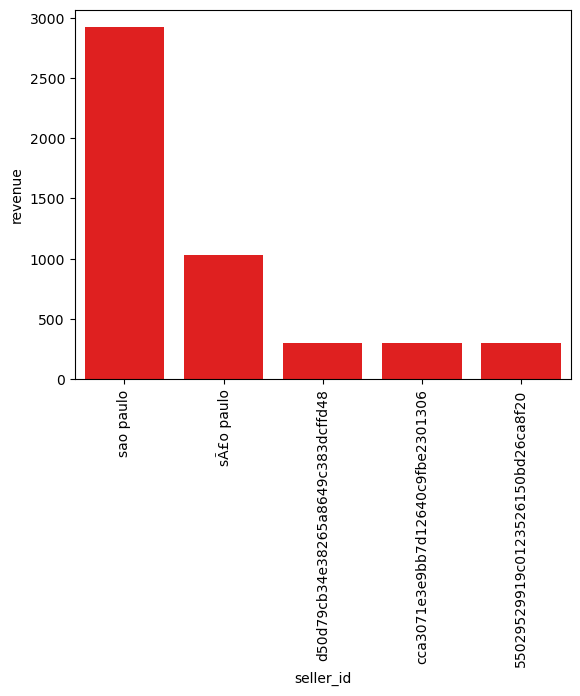

In [399]:
query = """ select * ,dense_rank() over (order by revenue desc) as rn from
(select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments 
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a
        """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["seller_id","revenue","rank"])
print(df)
df=df.head()
sns.barplot(x="seller_id",y="revenue",data=df,color="red")
plt.xticks(rotation=90)
plt.show()

#  Calculate the moving average of order values for each customer over their order history.

In [400]:
query = """ select customer_id,order_purchase_timestamp,avg(payments) over(partition by customer_id 
order by order_purchase_timestamp
rows between 2 preceding and current row)as mov_avg from
(select customer_id,order_purchase_timestamp,payments.payment_value as payments
from payments join orders 
on payments.order_id=orders.order_id)as a
        """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["customer_id","order_purchase_timestamp","Payments_avg"])
df

,customer_id,order_purchase_timestamp,Payments_avg
0,-23.51819009287688,c3867b4666c7d76867627c2f7fb22e21,30.00
1,-23.52011919677996,53e4c6e0f4312d4d2107a8c9cddf45cd,30.00
2,-23.522363706340684,8a32e327fe2c1b3511609d81aaf9f042,77.10
3,-23.522455392968503,campinas,30.00
4,-23.524057037191977,santo andre,30.00
...,...,...,...
672,fe4176df564772c058286208c0daa2a8,2017-05-01 18:58:54,12.22
673,fe4176df564772c058286208c0daa2a8,2017-05-01 18:58:54,12.22
674,ff5231b8a2bfe583c3ff95675d3f4c0e,2018-01-18 19:34:36,97.28
675,ff5231b8a2bfe583c3ff95675d3f4c0e,2018-01-18 19:34:36,97.28


#  Calculate the cumulative sales per month for each year.

In [401]:
query = """ select year_val,month_val, sum(total_payments) 
over(order by year_val,month_val)
from
(SELECT 
month(orders.order_purchase_timestamp) AS month_val,
year(orders.order_purchase_timestamp) as year_val,
       sum(payments.payment_value) AS total_payments
FROM orders join payments 
on orders.order_id=payments.order_id
GROUP BY month(orders.order_purchase_timestamp),
year(orders.order_purchase_timestamp)
) as a
group by year_val ,month_val
order by year_val,month_val 
        """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","Month","Sales_Count"])
df
                

,Year,Month,Sales_Count
0,NaN,NaN,5416.99
1,2016.0,10.0,5648.95
2,2017.0,2.0,6952.69
3,2017.0,3.0,8309.43
4,2017.0,4.0,15883.92
5,2017.0,5.0,25049.73
6,2017.0,6.0,26988.24
7,2017.0,7.0,28548.74
8,2017.0,8.0,34753.40
9,2017.0,9.0,39348.29


#  Calculate the year-over-year growth rate of total sales.

In [402]:
query = """ 
with a as
(
SELECT 
year(orders.order_purchase_timestamp) as year_val,
       round(sum(payments.payment_value),2) AS total_payments
FROM orders join payments 
on orders.order_id=payments.order_id
GROUP BY year_val )
select year_val,round((total_payments - lag(total_payments)  over(order by year_val))/lag(total_payments)  over(order by year_val)*100,2)
as yoy_growth
from a
order by year_val
     """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=["Year","yoy % growth"])
df


,Year,yoy % growth
0,NaN,NaN
1,2016.0,-95.72
2,2017.0,19252.98
3,2018.0,21.29


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [403]:


query = """ with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id=orders.customer_id
group by customers.customer_id),

b as(select a.customer_id,count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id=a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order,interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id=b.customer_id
        """

cur.execute(query)
data=cur.fetchall()
data            

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

In [427]:
query=""" select order_items.order_id,max(order_items.price) max_price ,
year(orders.order_purchase_timestamp)
from order_items join orders
on order_items.order_id=orders.order_id
group by order_items.order_id ,year(orders.order_purchase_timestamp)
order by max_price desc
"""
cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data,columns=["ID","Max price","order_dates"])
print(df.head())

                                 ID  Max price  order_dates
0  012f2c4ca09b101a73e18957c3294cd6    1820.00       2017.0
1                             01140    1050.61          NaN
2                             01140    1050.61       2017.0
3                             01121     989.00          NaN
4                             01141     738.90       2018.0


In [448]:
query="""select years,customer_id,payment,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp) ,orders.customer_id)as a
where d_rank<=3
"""
cur.execute(query)
data =cur.fetchall()
df=pd.DataFrame(data,columns=["Year","Customer_id","Payment","D_Rank"])
print(df.head())

   Year          Customer_id  Payment  D_Rank
0   NaN  -23.528899184286484   534.52       1
1   NaN  -23.535453394396647   377.46       2
2   NaN    -23.5313162761556   300.94       3
3   NaN   -23.53185275575627   300.94       3
4   NaN  -23.530686925616028   300.94       3
